### play game func

In [1]:
import numpy as np
import torch
from agent import Agent
from board import Board
from model import ConnectFourNN

def select_action(state, model:ConnectFourNN, epsilon):
    """
    Returns: col, reward\n
    a move chosen with eps-greedy policy and punishment for illegal moves 
    """
    reward = 0
    if np.random.rand() < epsilon:
        valid_moves = []
        for i in range(state.shape[1]):
            if state[0][i] == 0:
                valid_moves.append(i)
        return np.random.choice(valid_moves), reward
    else:
        with torch.no_grad():
            model.eval()
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            action_sorted = model(state_tensor).argsort(descending=True)
            for col in action_sorted[0]:
                if state[0][col] == 0:
                    return col, reward
                reward -= 0.15

def play_exp_game(agent1:Agent, agent2:Agent, type = 'greedy', eps = 0) -> tuple:
    """
    # Returns:
    list of experience from the game from both players
    """

    board = Board()
    agent1.board = board
    agent2.board = board
    curr_agent = agent2
    done = False

    states = []
    actions = []
    rewards = []
    next_states = []

    while not done:
        curr_agent = agent1 if curr_agent != agent1 else agent2

        state = curr_agent.get_board_state()
        action = curr_agent.choose_action(state, type='greedy', eps=eps)
        reward = curr_agent.perform_action(action)
        # state = board.pieces.copy()
        # action, action_reward = curr_agent.select_action(state = state, model = main_model, epsilon = eps)
        # board_reward, done = board.drop_piece(action, curr_player)
        # reward = action_reward + board_reward

        # update previous player if he lost or drew
        if reward == Board.rewards_dict['win']:
            rewards[-1] = Board.rewards_dict['loss']
        elif reward == Board.rewards_dict['draw']:
            rewards[-1] = Board.rewards_dict['draw']

        next_states.append(state)
        actions.append(action)
        rewards.append(reward)
        states.append(state)

        done = (reward != Board.rewards_dict['valid_move'])
    
    next_states.append(state)
    next_states.append(state)

    exp_list = []
    for i in range(len(rewards)):
        # next state is added with offset=2
        exp_list.append((states[i], actions[i], rewards[i], next_states[i+2]))

    return exp_list


def play_eval_game(main_agent:Agent, test_agent:Agent) -> int:
    """
    mask_moves: bool
     if `True` model is allowed to choose valid action\n
     if `False` model loses when choosing invalid action 
    # Returns:
    `1` - model win \n
    `0` - draw \n
    `-1` - test_model win \n
    """
    
    board = Board()
    main_agent.board = board
    test_agent.board = board
    curr_agent = test_agent
    done = False

    while not done:
        curr_agent = main_agent if curr_agent != main_agent else curr_agent

        state = curr_agent.get_board_state()
        action = curr_agent.choose_action(state, type='exploit', eps=0)
        reward = curr_agent.perform_action(action)

        done = (reward != Board.rewards_dict['valid_move'])

        if reward == Board.rewards_dict['win']:
            return 1 if curr_agent == main_agent else -1
        elif reward == Board.rewards_dict['illegal_move']:
            return -1 if curr_agent == main_agent else 1
        elif reward == Board.rewards_dict['draw']:
            return 0

### Train step func

In [2]:
import random
import torch.nn as nn

def train_step(main_model, target_model, optimizer, replay_buffer, gamma, batch_size, loss_class):
    if len(replay_buffer) < batch_size:
        return 0
    
    main_model.train()

    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states = zip(*batch)
    equal_flags = [np.array_equal(states[i], next_states[i]) for i in range(len(states))]

    states = torch.tensor(np.array(states), dtype=torch.float32).unsqueeze(1)
    actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).unsqueeze(1)
    dones = torch.tensor([1 if flag else 0 for flag in equal_flags])

    q_values = main_model(states).gather(1, actions).squeeze()

    next_q_values = target_model(next_states).max(1)[0]
    target_q_values = rewards + gamma * next_q_values * dones

    loss = loss_class()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.detach().numpy()

# Hyper Parameters

In [3]:
import torch.nn as nn

# TODO fine tune
eps = 1
eps_min = 0.01
eps_decay = 0.9995
epochs = 10**2
batch_size = 64
train_freq = 1
target_update_freq = 50
checkpoint_freq = epochs // 2
gamma = 0.98
lr = 3e-3

# TODO TEST OTHER
# loss_class = nn.MSELoss
loss_class = nn.HuberLoss


# Initialize Models

In [4]:
from model import ConnectFourNN
from replay_buffer import ReplayBuffer
import torch.optim as optim

"""
player 1 - player 2 - red
"""

def initialize_weights_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

main_model = ConnectFourNN()
main_model.apply(initialize_weights_he)

target_model = ConnectFourNN()
target_model.load_state_dict(main_model.state_dict())
target_model.eval()

replay_buffer = ReplayBuffer()

optimizer = optim.Adam(main_model.parameters(), lr = lr)

agent1 = Agent(main_model, piece_tag=1)
agent2 = Agent(main_model, piece_tag=2)

test_agent = Agent(torch.load("models/red_cp5_050724-055355.pth"), piece_tag=2)

# # RED INIT

# red_main_model = ConnectFourNN()
# red_main_model.apply(initialize_weights_he)

# red_target_model = ConnectFourNN()
# red_target_model.load_state_dict(red_main_model.state_dict())
# red_target_model.eval()

# red_replay_buffer = ReplayBuffer()

# red_optimizer = optim.Adam(red_main_model.parameters(), lr = lr)

# Training Loop

  2%|▏         | 2/100 [00:00<00:06, 16.26it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [0 0

  4%|▍         | 4/100 [00:00<00:05, 17.70it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0

c:\Users\cp\anaconda3\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  6%|▌         | 6/100 [00:01<00:23,  4.01it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0]
 [0 0

  9%|▉         | 9/100 [00:01<00:17,  5.33it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 11%|█         | 11/100 [00:01<00:14,  6.12it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 13%|█▎        | 13/100 [00:02<00:15,  5.47it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 15%|█▌        | 15/100 [00:02<00:14,  6.07it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 17%|█▋        | 17/100 [00:02<00:12,  6.50it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0

 19%|█▉        | 19/100 [00:03<00:11,  7.04it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 21%|██        | 21/100 [00:03<00:10,  7.31it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 23%|██▎       | 23/100 [00:03<00:10,  7.34it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 24%|██▍       | 24/100 [00:03<00:10,  7.25it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 26%|██▌       | 26/100 [00:04<00:12,  5.75it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 28%|██▊       | 28/100 [00:04<00:11,  6.53it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 30%|███       | 30/100 [00:04<00:09,  7.13it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 32%|███▏      | 32/100 [00:05<00:09,  7.15it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 34%|███▍      | 34/100 [00:05<00:09,  6.99it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 36%|███▌      | 36/100 [00:05<00:08,  7.17it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0

 37%|███▋      | 37/100 [00:05<00:08,  7.25it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]


 39%|███▉      | 39/100 [00:06<00:10,  5.90it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 41%|████      | 41/100 [00:06<00:09,  6.39it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 43%|████▎     | 43/100 [00:06<00:08,  6.70it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 45%|████▌     | 45/100 [00:06<00:07,  6.95it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 47%|████▋     | 47/100 [00:07<00:07,  6.97it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0

 49%|████▉     | 49/100 [00:07<00:07,  7.00it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0

 50%|█████     | 50/100 [00:07<00:07,  6.87it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 1 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0

 52%|█████▏    | 52/100 [00:08<00:10,  4.78it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 53%|█████▎    | 53/100 [00:08<00:08,  5.23it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 1 0 1 0]]
[[0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 55%|█████▌    | 55/100 [00:08<00:08,  5.49it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1

 57%|█████▋    | 57/100 [00:09<00:07,  6.02it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 59%|█████▉    | 59/100 [00:09<00:07,  5.50it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 60%|██████    | 60/100 [00:09<00:07,  5.25it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 0 1 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0]
 [0 1 0 0 1 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 1]
 [1 0 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 1 1 0 0]
 [0 1 0 0 1 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 1 0 0 0 0 1]
 [1 0 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 1 1 0 0]
 [0 1 1 0 1 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1]
 [1 1

 61%|██████    | 61/100 [00:09<00:07,  5.38it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0

 63%|██████▎   | 63/100 [00:10<00:07,  4.93it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]
 [1 0

 65%|██████▌   | 65/100 [00:10<00:06,  5.76it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0

 66%|██████▌   | 66/100 [00:10<00:05,  5.75it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0]
 [1 1 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 1 1 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 1 1 0 0 0 0]
 [1 1 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0

 68%|██████▊   | 68/100 [00:11<00:05,  5.92it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 69%|██████▉   | 69/100 [00:11<00:05,  5.92it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 1 0 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 1 0 0]
 [1 0 0 0 1 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1]
 [0 0 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 1 1 0]
 [1 0 0 0 1 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 1]
 [1 0 0 0 0 0 1]
 [0 0 0 1 0 0 1]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 71%|███████   | 71/100 [00:11<00:04,  6.24it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0

 72%|███████▏  | 72/100 [00:11<00:04,  6.71it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0

 74%|███████▍  | 74/100 [00:12<00:04,  5.35it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0

 76%|███████▌  | 76/100 [00:12<00:04,  5.56it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 77%|███████▋  | 77/100 [00:12<00:04,  5.70it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 78%|███████▊  | 78/100 [00:12<00:04,  5.47it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 1 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 1 1 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 79%|███████▉  | 79/100 [00:13<00:03,  5.44it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0

 80%|████████  | 80/100 [00:13<00:03,  5.27it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]
 [0 0 0 1 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0

 81%|████████  | 81/100 [00:13<00:03,  4.80it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0

 83%|████████▎ | 83/100 [00:14<00:03,  4.36it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 84%|████████▍ | 84/100 [00:14<00:03,  4.54it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 1 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0

 85%|████████▌ | 85/100 [00:14<00:03,  4.76it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0

 86%|████████▌ | 86/100 [00:14<00:02,  4.94it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0

 87%|████████▋ | 87/100 [00:14<00:02,  5.16it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0

 88%|████████▊ | 88/100 [00:15<00:02,  5.22it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0

 90%|█████████ | 90/100 [00:15<00:01,  5.60it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0

 92%|█████████▏| 92/100 [00:15<00:01,  5.78it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0

 93%|█████████▎| 93/100 [00:15<00:01,  5.61it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 95%|█████████▌| 95/100 [00:16<00:01,  4.41it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0

 96%|█████████▌| 96/100 [00:16<00:00,  4.83it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0

 98%|█████████▊| 98/100 [00:16<00:00,  5.47it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0]
 [0 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

 99%|█████████▉| 99/100 [00:17<00:00,  5.48it/s]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [1 0 1 0 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0

100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


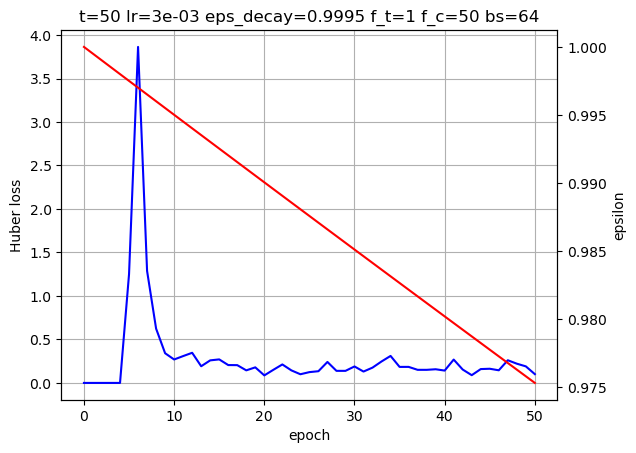

In [5]:
from datetime import datetime
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

losses = []
times = []
EPS = []
results = []
points = 0

for t in tqdm(range(epochs)):
    exp_list = play_exp_game(agent1, agent2, eps)
    
    replay_buffer.extend(exp_list)

    if not t % train_freq:
        loss = train_step(main_model, target_model, optimizer, replay_buffer, gamma, batch_size, loss_class)

        if len(replay_buffer) > 1000:
            replay_buffer.clear_oldest(train_freq * len(exp_list))

        times.append(t)
        losses.append(loss)
        EPS.append(eps)
        result = 0
        for _ in range(100):
            result += play_eval_game(agent1, test_agent)
        result.append(result)

    if not t % target_update_freq:
        target_model.load_state_dict(main_model.state_dict())
        

    if not t % checkpoint_freq and t != 0:
        stamp = datetime.now().strftime("%d%m%y-%H%M%S")
        path = rf'models/cp{t//checkpoint_freq}_{stamp}.pth'
        torch.save(main_model, path)

        plt.clf()
        plt.plot(times, losses, 'b-')
        plt.xlabel("epoch")
        plt.ylabel("Huber loss")
        plt.grid()
        ax2 = plt.twinx()
        ax2.plot(times, EPS, 'r-')
        ax2.set_ylabel('epsilon')
        plt.title(f't={t} lr={lr:.0e} eps_decay={eps_decay} f_t={train_freq} f_c={target_update_freq} bs={batch_size}')

    eps = max(eps_min, eps_decay * eps)
    plt.figure()
    plt.plot(times, results)
